In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.neural_network import MLPClassifier
from keras.models import Sequential
from keras.layers import Dense
from scikeras.wrappers import KerasRegressor
from scikeras.wrappers import KerasClassifier
from keras.optimizers import Adam

## Problem Statement: Predicting turbine energy yield (TEY) using ambient variables as features.

In [2]:
gas = pd.read_csv('gas_turbines.csv')
gas.head()

,AT,AP,AH,AFDP,GTEP,TIT,TAT,TEY,CDP,CO,NOX
0,6.8594,1007.9,96.799,3.5000,19.663,1059.2,550.00,114.70,10.605,3.1547,82.722
1,6.7850,1008.4,97.118,3.4998,19.728,1059.3,550.00,114.72,10.598,3.2363,82.776
2,6.8977,1008.8,95.939,3.4824,19.779,1059.4,549.87,114.71,10.601,3.2012,82.468
3,7.0569,1009.2,95.249,3.4805,19.792,1059.6,549.99,114.72,10.606,3.1923,82.670
4,7.3978,1009.7,95.150,3.4976,19.765,1059.7,549.98,114.72,10.612,3.2484,82.311


In [3]:
gas.describe().T

,count,mean,std,min,25%,50%,75%,max
AT,15039.0,17.764381,7.574323,0.522300,11.408000,18.1860,23.8625,34.9290
AP,15039.0,1013.199240,6.410760,985.850000,1008.900000,1012.8000,1016.9000,1034.2000
AH,15039.0,79.124174,13.793439,30.344000,69.750000,82.2660,90.0435,100.2000
AFDP,15039.0,4.200294,0.760197,2.087400,3.723900,4.1862,4.5509,7.6106
GTEP,15039.0,25.419061,4.173916,17.878000,23.294000,25.0820,27.1840,37.4020
TIT,15039.0,1083.798770,16.527806,1000.800000,1079.600000,1088.7000,1096.0000,1100.8000
TAT,15039.0,545.396183,7.866803,512.450000,542.170000,549.8900,550.0600,550.6100
TEY,15039.0,134.188464,15.829717,100.170000,127.985000,133.7800,140.8950,174.6100
CDP,15039.0,12.102353,1.103196,9.904400,11.622000,12.0250,12.5780,15.0810
CO,15039.0,1.972499,2.222206,0.000388,0.858055,1.3902,2.1604,44.1030


In [4]:
gas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15039 entries, 0 to 15038
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AT      15039 non-null  float64
 1   AP      15039 non-null  float64
 2   AH      15039 non-null  float64
 3   AFDP    15039 non-null  float64
 4   GTEP    15039 non-null  float64
 5   TIT     15039 non-null  float64
 6   TAT     15039 non-null  float64
 7   TEY     15039 non-null  float64
 8   CDP     15039 non-null  float64
 9   CO      15039 non-null  float64
 10  NOX     15039 non-null  float64
dtypes: float64(11)
memory usage: 1.3 MB


In [5]:
def column_boxplots(df,list_cols):
    for i in list_cols:    
        sns.boxplot(x=i, data = df)
        plt.show()

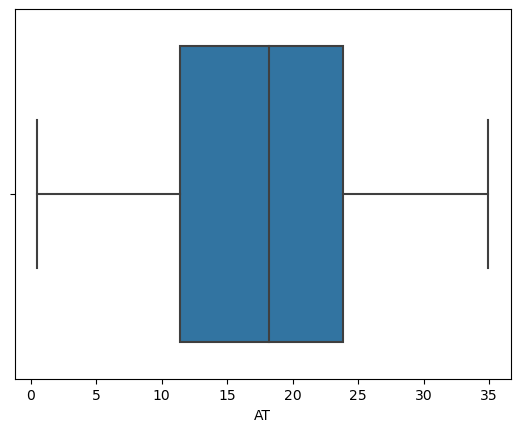

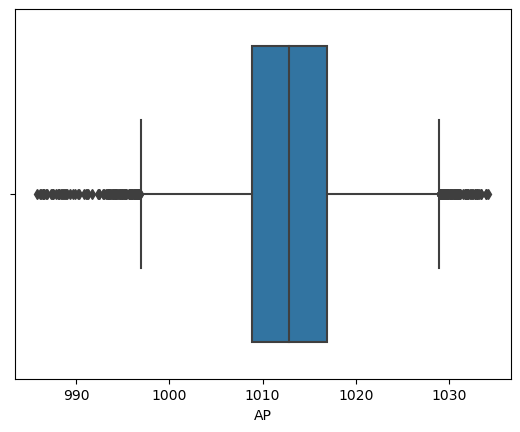

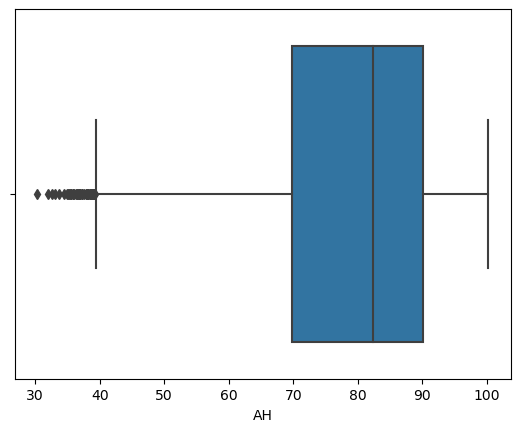

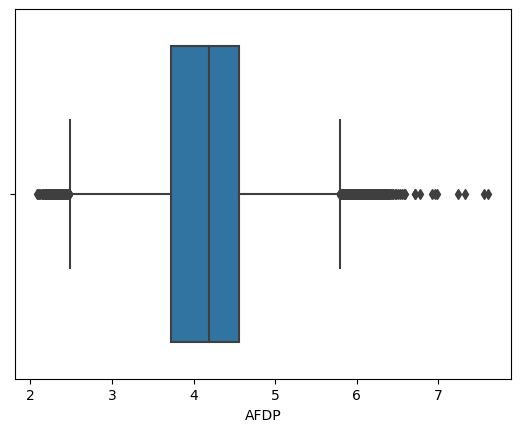

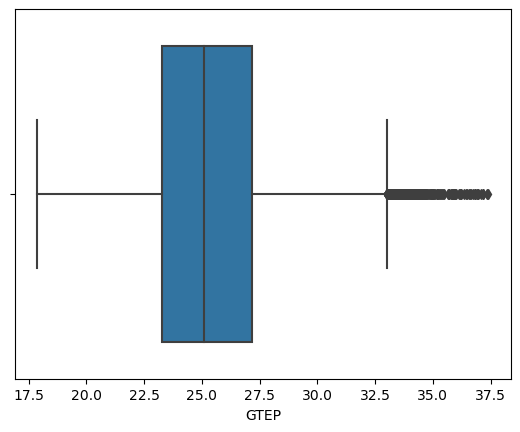

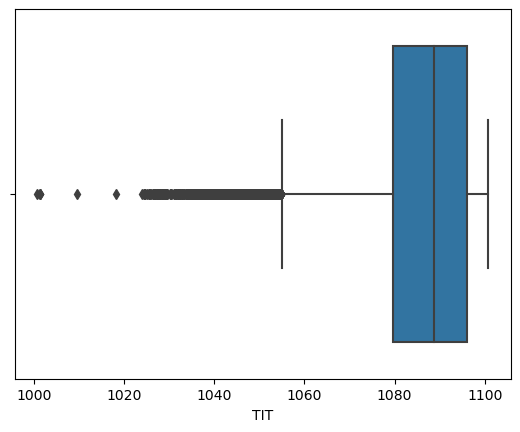

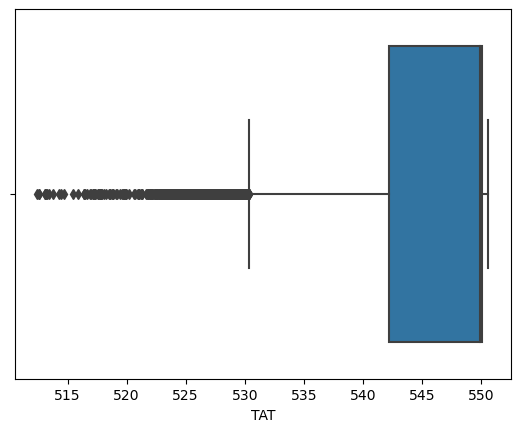

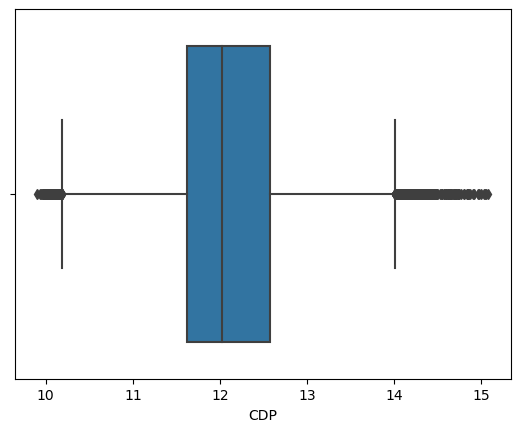

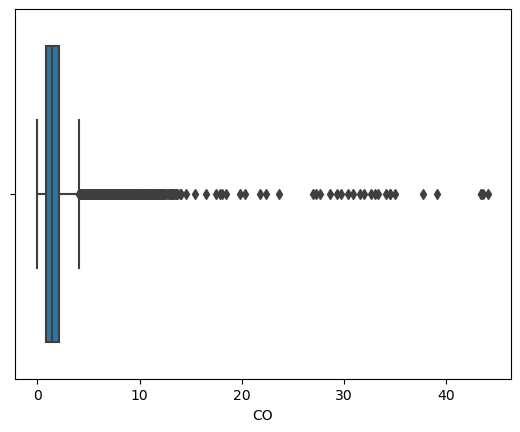

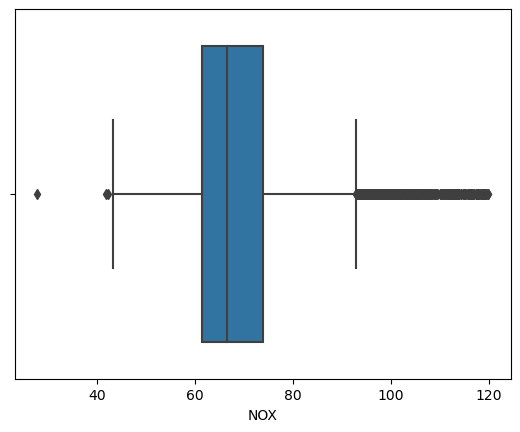

In [6]:
column_boxplots(gas,gas.drop(columns='TEY').columns)

Let's try to deal with the outlier columns

In [7]:
def outliers_to_median_values(df,column_name):
    
    Q1 = df[column_name].quantile(0.25)
    Q3 = df[column_name].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column_name] < lower_bound) | (df[column_name] > upper_bound)]

    # Calculate the median of the non-outlier data
    median = df[(df[column_name] >= lower_bound) & (df[column_name] <= upper_bound)][column_name].median()

    # Replace outliers with the median
    df.loc[(df[column_name] < lower_bound) | (df[column_name] > upper_bound), column_name] = median
    print('Distribution after outlier removal')
    sns.boxplot(x=column_name,data=df)
    plt.show()

Distribution after outlier removal


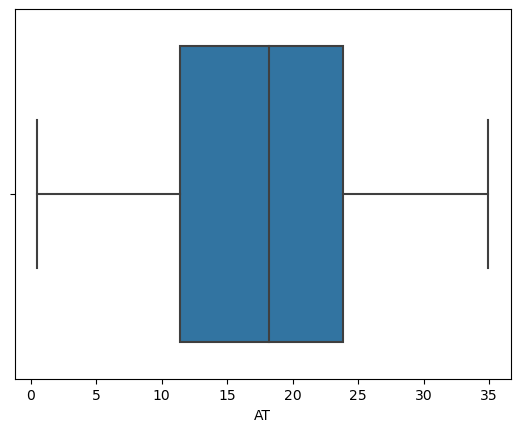

Distribution after outlier removal


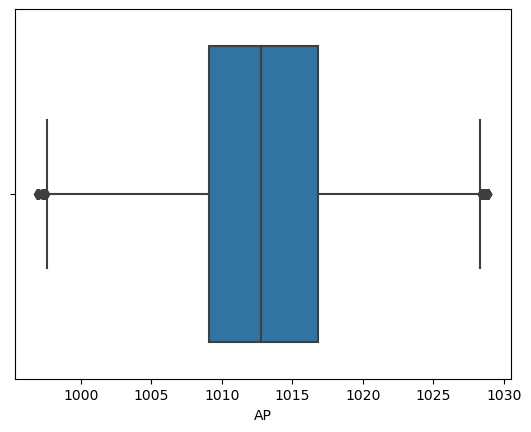

Distribution after outlier removal


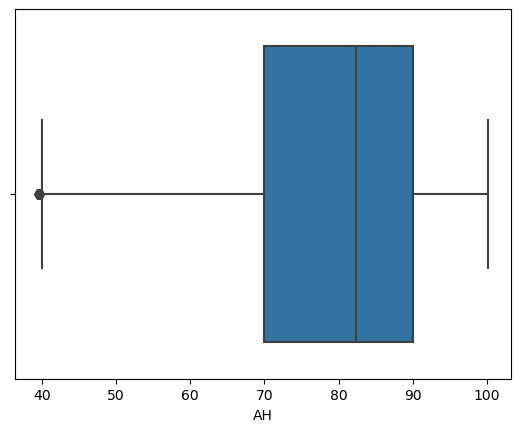

Distribution after outlier removal


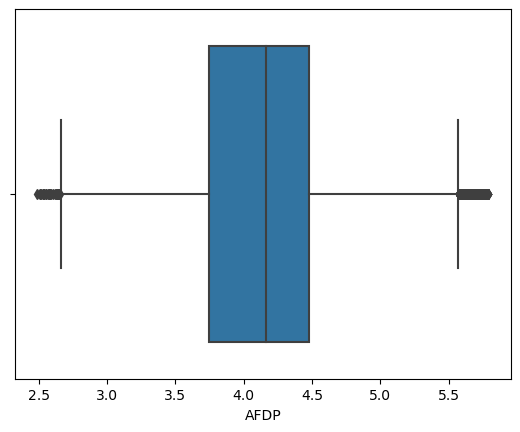

Distribution after outlier removal


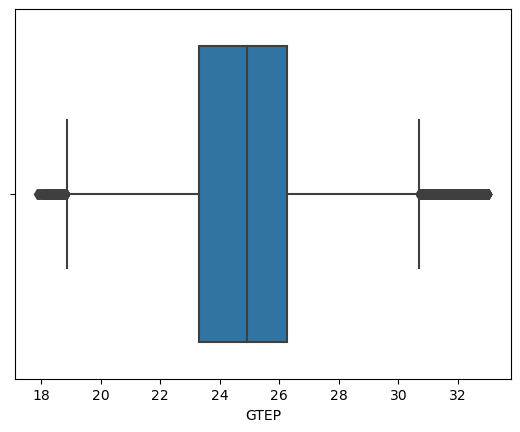

Distribution after outlier removal


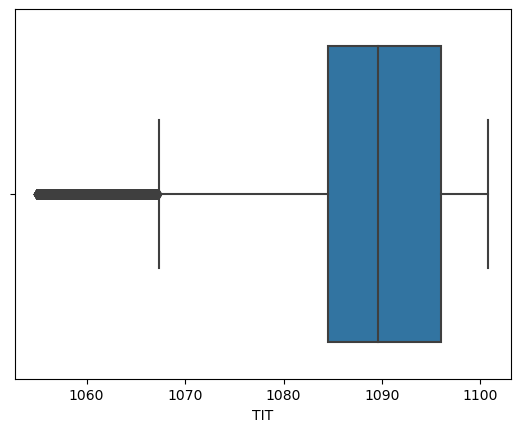

Distribution after outlier removal


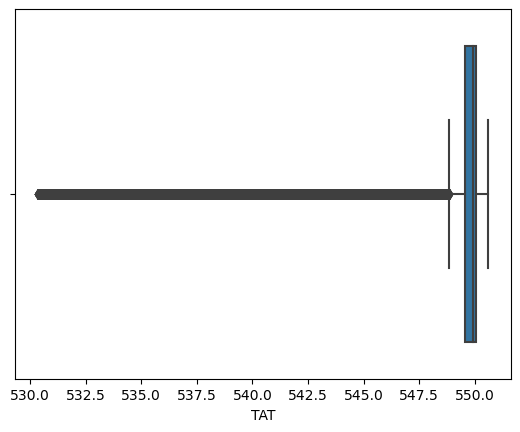

Distribution after outlier removal


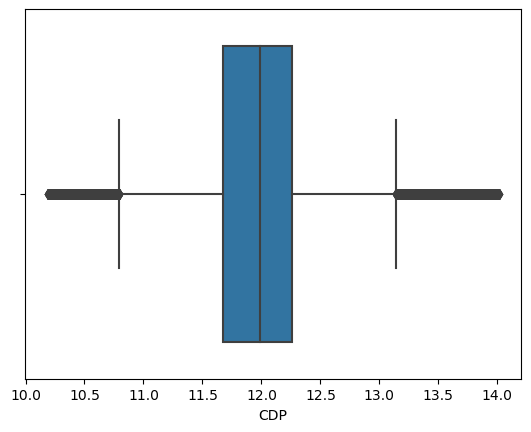

Distribution after outlier removal


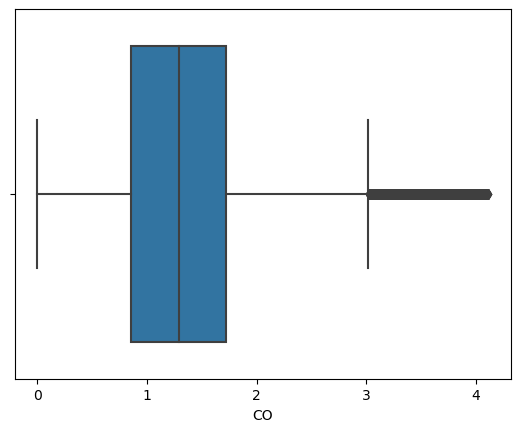

Distribution after outlier removal


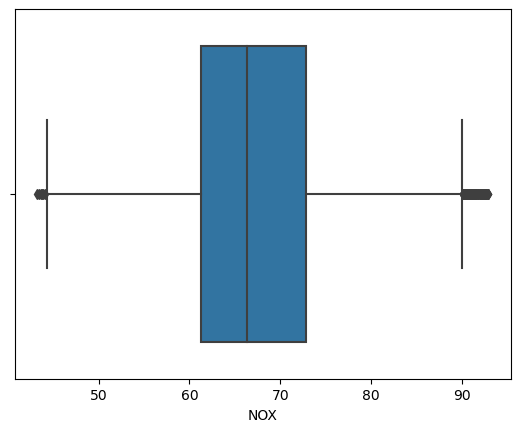

In [8]:
for i in gas.drop(columns='TEY').columns:
    outliers_to_median_values(gas,i)

In [9]:
X = gas.drop(columns='TEY')

y = gas['TEY']

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.30)

## ANN

Let's scale our train data

In [11]:
ss = StandardScaler()

In [12]:
X_train_scaled = pd.DataFrame(ss.fit_transform(X_train),columns=X_train.columns)
X_train_scaled.head()

,AT,AP,AH,AFDP,GTEP,TIT,TAT,CDP,CO,NOX
0,-1.514211,-0.085542,0.988179,-0.121746,-0.328488,-0.134025,0.481195,-0.090270,0.867040,1.776434
1,-0.159785,1.451690,0.186462,0.330337,-0.067462,0.225996,0.524117,0.068216,-0.487538,-0.512537
2,-0.478680,0.365602,0.575813,-2.047021,-0.144421,-0.026785,0.479329,-0.093419,0.725231,-0.352503
3,-0.328128,1.217763,0.379293,1.973452,1.694928,1.045618,-2.586790,1.930161,-1.132769,-0.441334
4,0.547040,-1.739738,-0.635320,1.618400,0.109729,0.126416,0.458801,0.007341,0.168540,0.851951


In [13]:
X_test_scaled = pd.DataFrame(ss.fit_transform(X_test),columns=X_test.columns)
X_test_scaled.head()

,AT,AP,AH,AFDP,GTEP,TIT,TAT,CDP,CO,NOX
0,1.201459,0.373458,-1.467126,-1.362668,-1.237809,-1.919933,0.449048,-1.510902,0.996128,-1.664643
1,0.115440,-0.025033,0.664162,1.591499,-0.037198,0.102397,0.548229,0.042925,-0.151169,-0.107216
2,-0.171679,-0.971448,1.072625,1.725375,1.711384,1.020224,-2.692917,1.834977,-0.000120,-0.143579
3,-0.141428,-0.191071,0.967925,-0.789488,-1.509519,-2.402181,0.467762,-1.598895,-0.140423,-0.352238
4,-0.765866,1.436099,0.009012,1.853493,-0.050716,0.996890,0.460276,-0.003218,-0.135956,-0.487367


### MLP Regressor

In [14]:
nnreg = MLPRegressor(hidden_layer_sizes=20
                     ,max_iter=1000
                     ,solver='sgd'
                     ,activation='tanh'
                     ,verbose=True
                     ,tol=0.0001,
                     learning_rate='constant',
                     learning_rate_init=0.001
)

In [15]:
nnreg.fit(X_train_scaled,y_train)

Iteration 1, loss = 1884.91900147
Iteration 2, loss = 31.53497548
Iteration 3, loss = 13.63645207
Iteration 4, loss = 8.48970071
Iteration 5, loss = 6.22600222
Iteration 6, loss = 4.94155098
Iteration 7, loss = 4.16310315
Iteration 8, loss = 3.64095620
Iteration 9, loss = 3.23817119
Iteration 10, loss = 2.92192146
Iteration 11, loss = 2.67048532
Iteration 12, loss = 2.44901500
Iteration 13, loss = 2.26312964
Iteration 14, loss = 2.11423607
Iteration 15, loss = 1.98950939
Iteration 16, loss = 1.87696280
Iteration 17, loss = 1.77629993
Iteration 18, loss = 1.67600802
Iteration 19, loss = 1.59433164
Iteration 20, loss = 1.52135639
Iteration 21, loss = 1.46612639
Iteration 22, loss = 1.41734933
Iteration 23, loss = 1.37561958
Iteration 24, loss = 1.34511666
Iteration 25, loss = 1.32179939
Iteration 26, loss = 1.29374095
Iteration 27, loss = 1.27532131
Iteration 28, loss = 1.25506223
Iteration 29, loss = 1.23931244
Iteration 30, loss = 1.22807215
Iteration 31, loss = 1.21249166
Iteration 32

Iteration 256, loss = 0.53922748
Iteration 257, loss = 0.53916760
Iteration 258, loss = 0.53843653
Iteration 259, loss = 0.53905075
Iteration 260, loss = 0.53860661
Iteration 261, loss = 0.53630145
Iteration 262, loss = 0.53467944
Iteration 263, loss = 0.53439358
Iteration 264, loss = 0.53439729
Iteration 265, loss = 0.53473657
Iteration 266, loss = 0.53312028
Iteration 267, loss = 0.53199247
Iteration 268, loss = 0.53218122
Iteration 269, loss = 0.53190566
Iteration 270, loss = 0.53031091
Iteration 271, loss = 0.52867890
Iteration 272, loss = 0.52838131
Iteration 273, loss = 0.52645964
Iteration 274, loss = 0.52696374
Iteration 275, loss = 0.52535177
Iteration 276, loss = 0.52531044
Iteration 277, loss = 0.52432365
Iteration 278, loss = 0.52560545
Iteration 279, loss = 0.52513922
Iteration 280, loss = 0.52278565
Iteration 281, loss = 0.52260934
Iteration 282, loss = 0.52092253
Iteration 283, loss = 0.52132033
Iteration 284, loss = 0.51985782
Iteration 285, loss = 0.52001942
Iteration 

Iteration 510, loss = 0.45305563
Iteration 511, loss = 0.45280387
Iteration 512, loss = 0.45040638
Iteration 513, loss = 0.45176542
Iteration 514, loss = 0.45227627
Iteration 515, loss = 0.45166701
Iteration 516, loss = 0.45157100
Iteration 517, loss = 0.45103105
Iteration 518, loss = 0.45009401
Iteration 519, loss = 0.44922589
Iteration 520, loss = 0.44933873
Iteration 521, loss = 0.45031700
Iteration 522, loss = 0.45062530
Iteration 523, loss = 0.44870715
Iteration 524, loss = 0.44910325
Iteration 525, loss = 0.44893138
Iteration 526, loss = 0.44953933
Iteration 527, loss = 0.44873476
Iteration 528, loss = 0.44697081
Iteration 529, loss = 0.44874139
Iteration 530, loss = 0.44826394
Iteration 531, loss = 0.44736432
Iteration 532, loss = 0.44803538
Iteration 533, loss = 0.44801262
Iteration 534, loss = 0.44696306
Iteration 535, loss = 0.44581474
Iteration 536, loss = 0.44643645
Iteration 537, loss = 0.44635355
Iteration 538, loss = 0.44544931
Iteration 539, loss = 0.44565753
Iteration 

MLPRegressor(activation='tanh', hidden_layer_sizes=20, max_iter=1000,
             solver='sgd', verbose=True)

In [16]:
y_train_predict = nnreg.predict(X_train_scaled)
y_test_predict = nnreg.predict(X_test_scaled)

In [17]:
print(nnreg.score(X_train_scaled, y_train))
print(nnreg.score(X_test_scaled, y_test))

0.9965735228086218
0.9964256923678617


Let's perform hyper-parameter tuning for the model and check whether the score are having any impact

In [18]:
nnreg = MLPRegressor(hidden_layer_sizes=10
                     ,max_iter=1000
                     ,solver='adam'
                     ,activation='relu'
                     ,verbose=True
                     ,tol=0.0001,
                     learning_rate='adaptive',
                     learning_rate_init=0.002
)

nnreg.fit(X_train_scaled,y_train)
y_train_predict = nnreg.predict(X_train_scaled)
y_test_predict = nnreg.predict(X_test_scaled)
print(nnreg.score(X_train_scaled, y_train))
print(nnreg.score(X_test_scaled, y_test))

Iteration 1, loss = 9138.43190788
Iteration 2, loss = 8971.86283561
Iteration 3, loss = 8774.65672982
Iteration 4, loss = 8516.83153350
Iteration 5, loss = 8166.20187544
Iteration 6, loss = 7711.75755711
Iteration 7, loss = 7164.78586042
Iteration 8, loss = 6538.33941257
Iteration 9, loss = 5865.41705400
Iteration 10, loss = 5189.98704212
Iteration 11, loss = 4546.17552351
Iteration 12, loss = 3958.77893472
Iteration 13, loss = 3441.61299760
Iteration 14, loss = 3000.58961041
Iteration 15, loss = 2632.17241191
Iteration 16, loss = 2328.13684986
Iteration 17, loss = 2076.33602082
Iteration 18, loss = 1864.70438117
Iteration 19, loss = 1683.79306576
Iteration 20, loss = 1526.22866613
Iteration 21, loss = 1388.26335049
Iteration 22, loss = 1268.12365379
Iteration 23, loss = 1162.82091808
Iteration 24, loss = 1071.23257836
Iteration 25, loss = 990.84106886
Iteration 26, loss = 918.80837318
Iteration 27, loss = 854.44185211
Iteration 28, loss = 795.58007988
Iteration 29, loss = 741.51607301

Iteration 250, loss = 1.70812866
Iteration 251, loss = 1.69567985
Iteration 252, loss = 1.69031528
Iteration 253, loss = 1.68265566
Iteration 254, loss = 1.67435025
Iteration 255, loss = 1.67258551
Iteration 256, loss = 1.66684249
Iteration 257, loss = 1.64832270
Iteration 258, loss = 1.65013347
Iteration 259, loss = 1.65190493
Iteration 260, loss = 1.63611440
Iteration 261, loss = 1.63061962
Iteration 262, loss = 1.62152374
Iteration 263, loss = 1.61515324
Iteration 264, loss = 1.61060755
Iteration 265, loss = 1.61653296
Iteration 266, loss = 1.60858808
Iteration 267, loss = 1.60097296
Iteration 268, loss = 1.59269457
Iteration 269, loss = 1.58410753
Iteration 270, loss = 1.58762592
Iteration 271, loss = 1.57740786
Iteration 272, loss = 1.56458365
Iteration 273, loss = 1.56592113
Iteration 274, loss = 1.55800078
Iteration 275, loss = 1.56004418
Iteration 276, loss = 1.55562214
Iteration 277, loss = 1.54163060
Iteration 278, loss = 1.54075702
Iteration 279, loss = 1.53610093
Iteration 

Iteration 507, loss = 1.02114301
Iteration 508, loss = 1.01541811
Iteration 509, loss = 1.01085388
Iteration 510, loss = 1.01287069
Iteration 511, loss = 1.01591848
Iteration 512, loss = 1.01068358
Iteration 513, loss = 1.01006169
Iteration 514, loss = 1.00830921
Iteration 515, loss = 1.01121775
Iteration 516, loss = 1.00459588
Iteration 517, loss = 1.00469732
Iteration 518, loss = 1.01115219
Iteration 519, loss = 1.00262454
Iteration 520, loss = 1.00266964
Iteration 521, loss = 0.99830570
Iteration 522, loss = 1.00585965
Iteration 523, loss = 1.00020436
Iteration 524, loss = 0.99654948
Iteration 525, loss = 0.99635658
Iteration 526, loss = 1.00198614
Iteration 527, loss = 0.99573154
Iteration 528, loss = 0.99854904
Iteration 529, loss = 0.99138438
Iteration 530, loss = 0.99387738
Iteration 531, loss = 0.99145275
Iteration 532, loss = 0.98976388
Iteration 533, loss = 0.99078575
Iteration 534, loss = 0.99256003
Iteration 535, loss = 0.98698147
Iteration 536, loss = 0.98612886
Iteration 

Iteration 762, loss = 0.81074356
Iteration 763, loss = 0.81608991
Iteration 764, loss = 0.81287160
Iteration 765, loss = 0.80538046
Iteration 766, loss = 0.80785369
Iteration 767, loss = 0.80693690
Iteration 768, loss = 0.80940503
Iteration 769, loss = 0.80875509
Iteration 770, loss = 0.80549827
Iteration 771, loss = 0.80557252
Iteration 772, loss = 0.80711781
Iteration 773, loss = 0.80401804
Iteration 774, loss = 0.80422586
Iteration 775, loss = 0.79966677
Iteration 776, loss = 0.81021664
Iteration 777, loss = 0.80452243
Iteration 778, loss = 0.80080889
Iteration 779, loss = 0.80256691
Iteration 780, loss = 0.80532302
Iteration 781, loss = 0.80222695
Iteration 782, loss = 0.80163809
Iteration 783, loss = 0.80107505
Iteration 784, loss = 0.79846045
Iteration 785, loss = 0.80537790
Iteration 786, loss = 0.79839784
Iteration 787, loss = 0.79991796
Iteration 788, loss = 0.80365850
Iteration 789, loss = 0.79835887
Iteration 790, loss = 0.80144446
Iteration 791, loss = 0.79872060
Iteration 

### Keras Regressor

In [19]:
model = Sequential()
model.add(Dense(10, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(25, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

model.fit(X_train_scaled, y_train, epochs=50, batch_size=32, verbose=1, validation_split=0.1)

score = model.evaluate(X_test_scaled, y_test, verbose=0)
print('Test loss:', score)

predictions = model.predict(X_test_scaled)

Epoch 1/50
297/297 [==============================] - 3s 4ms/step - loss: 14287.8223 - val_loss: 6269.5732
Epoch 2/50
297/297 [==============================] - 1s 3ms/step - loss: 2304.8755 - val_loss: 994.8672
Epoch 3/50
297/297 [==============================] - 1s 3ms/step - loss: 763.5058 - val_loss: 578.9642
Epoch 4/50
297/297 [==============================] - 1s 3ms/step - loss: 475.5489 - val_loss: 382.6674
Epoch 5/50
297/297 [==============================] - 1s 3ms/step - loss: 315.1871 - val_loss: 258.6646
Epoch 6/50
297/297 [==============================] - 1s 3ms/step - loss: 217.3837 - val_loss: 180.6820
Epoch 7/50
297/297 [==============================] - 1s 4ms/step - loss: 155.1856 - val_loss: 131.1818
Epoch 8/50
297/297 [==============================] - 1s 3ms/step - loss: 113.8791 - val_loss: 96.6021
Epoch 9/50
297/297 [==============================] - 1s 3ms/step - loss: 86.3636 - val_loss: 73.7180
Epoch 10/50
297/297 [==============================] - 1s 3ms/s

## Problem Statement: Predict the burned area of forest fires with Neural Networks

In [20]:
forestfires = pd.read_csv('forestfires.csv')
forestfires.head()

,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,...,monthfeb,monthjan,monthjul,monthjun,monthmar,monthmay,monthnov,monthoct,monthsep,size_category
0,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,...,0,0,0,0,1,0,0,0,0,small
1,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,...,0,0,0,0,0,0,0,1,0,small
2,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,...,0,0,0,0,0,0,0,1,0,small
3,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,...,0,0,0,0,1,0,0,0,0,small
4,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,...,0,0,0,0,1,0,0,0,0,small


In [21]:
forestfires.columns

Index(['month', 'day', 'FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind',
       'rain', 'area', 'dayfri', 'daymon', 'daysat', 'daysun', 'daythu',
       'daytue', 'daywed', 'monthapr', 'monthaug', 'monthdec', 'monthfeb',
       'monthjan', 'monthjul', 'monthjun', 'monthmar', 'monthmay', 'monthnov',
       'monthoct', 'monthsep', 'size_category'],
      dtype='object')

In [22]:
forestfires['size_category'].value_counts()

size_category
small    378
large    139
Name: count, dtype: int64

In [23]:
forestfires['FFMC'].value_counts()

FFMC
92.1    28
91.6    28
91.0    22
91.7    19
92.4    16
        ..
86.9     1
85.2     1
53.4     1
85.1     1
94.4     1
Name: count, Length: 106, dtype: int64

In [24]:
forestfires.describe().T

,count,mean,std,min,25%,50%,75%,max
FFMC,517.0,90.644681,5.520111,18.7,90.2,91.60,92.90,96.20
DMC,517.0,110.872340,64.046482,1.1,68.6,108.30,142.40,291.30
DC,517.0,547.940039,248.066192,7.9,437.7,664.20,713.90,860.60
ISI,517.0,9.021663,4.559477,0.0,6.5,8.40,10.80,56.10
temp,517.0,18.889168,5.806625,2.2,15.5,19.30,22.80,33.30
RH,517.0,44.288201,16.317469,15.0,33.0,42.00,53.00,100.00
wind,517.0,4.017602,1.791653,0.4,2.7,4.00,4.90,9.40
rain,517.0,0.021663,0.295959,0.0,0.0,0.00,0.00,6.40
area,517.0,12.847292,63.655818,0.0,0.0,0.52,6.57,1090.84
dayfri,517.0,0.164410,0.371006,0.0,0.0,0.00,0.00,1.00


In [25]:
forestfires.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 31 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   month          517 non-null    object 
 1   day            517 non-null    object 
 2   FFMC           517 non-null    float64
 3   DMC            517 non-null    float64
 4   DC             517 non-null    float64
 5   ISI            517 non-null    float64
 6   temp           517 non-null    float64
 7   RH             517 non-null    int64  
 8   wind           517 non-null    float64
 9   rain           517 non-null    float64
 10  area           517 non-null    float64
 11  dayfri         517 non-null    int64  
 12  daymon         517 non-null    int64  
 13  daysat         517 non-null    int64  
 14  daysun         517 non-null    int64  
 15  daythu         517 non-null    int64  
 16  daytue         517 non-null    int64  
 17  daywed         517 non-null    int64  
 18  monthapr  

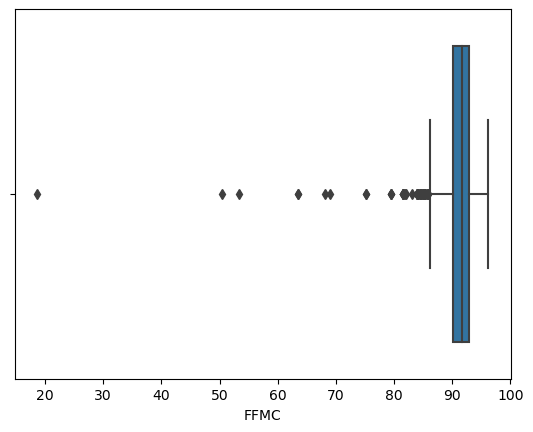

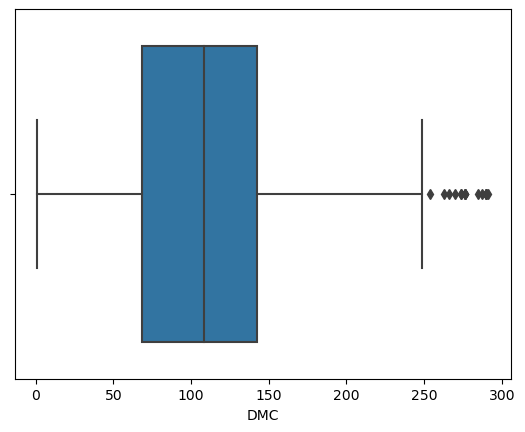

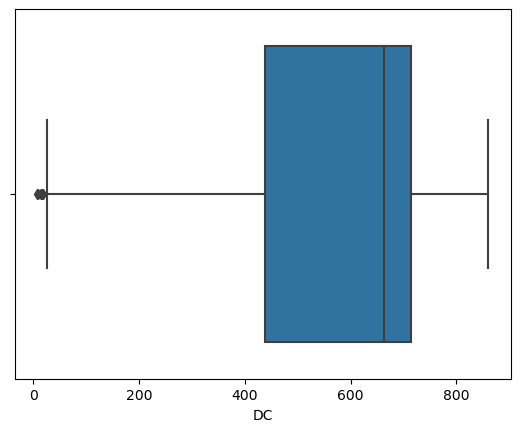

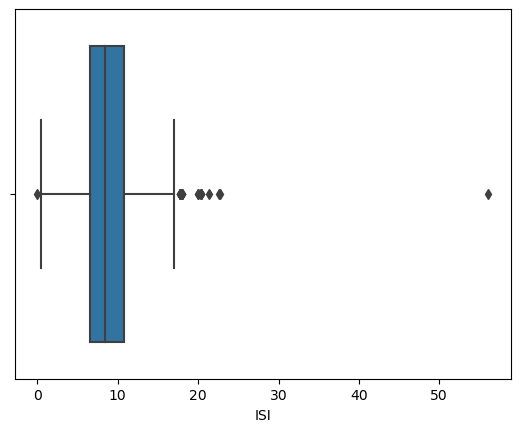

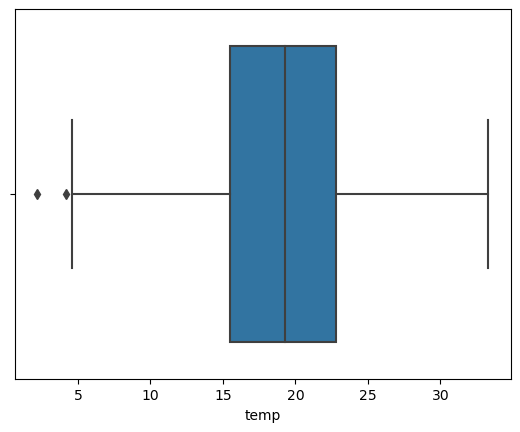

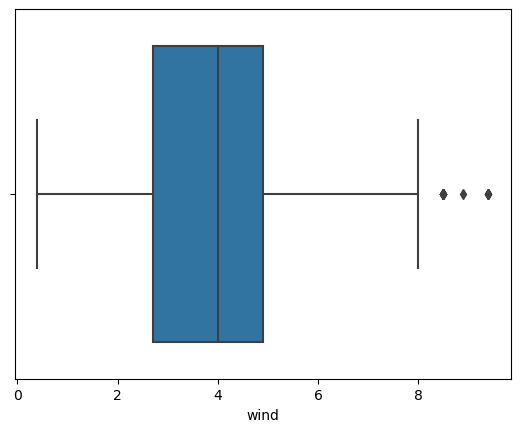

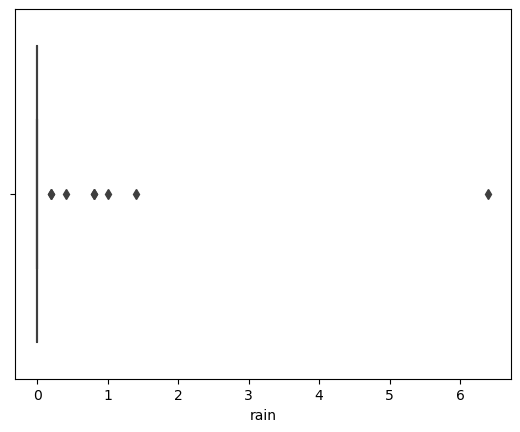

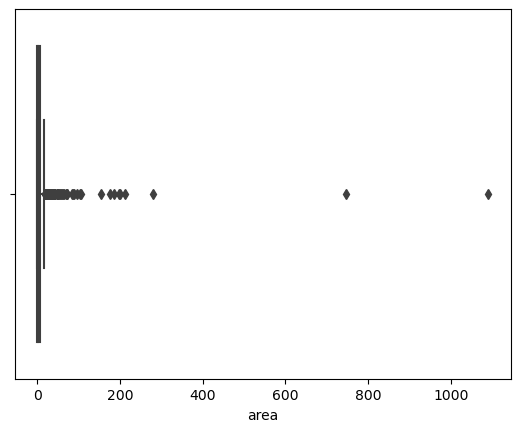

In [26]:
column_boxplots(forestfires,[x for x in forestfires.columns if forestfires[x].dtype == 'float64'])

Distribution after outlier removal


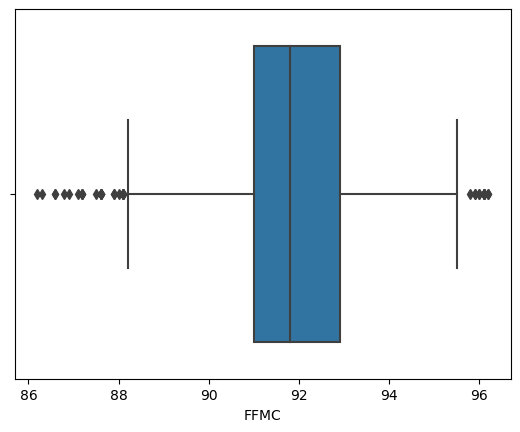

Distribution after outlier removal


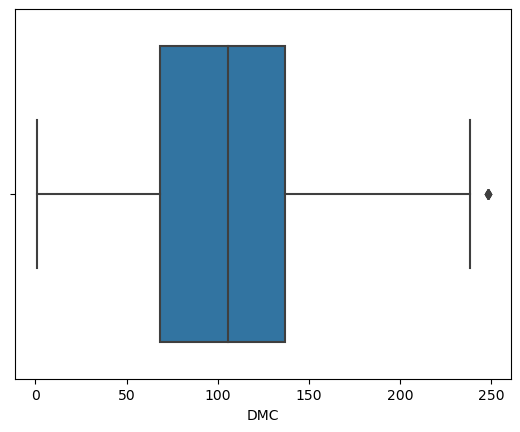

Distribution after outlier removal


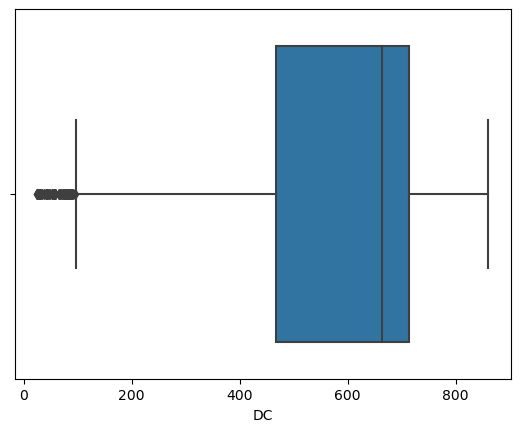

Distribution after outlier removal


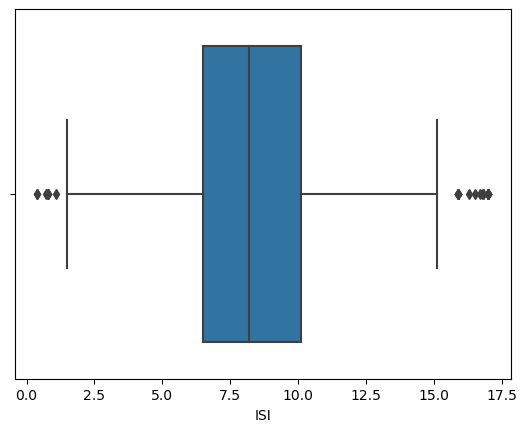

Distribution after outlier removal


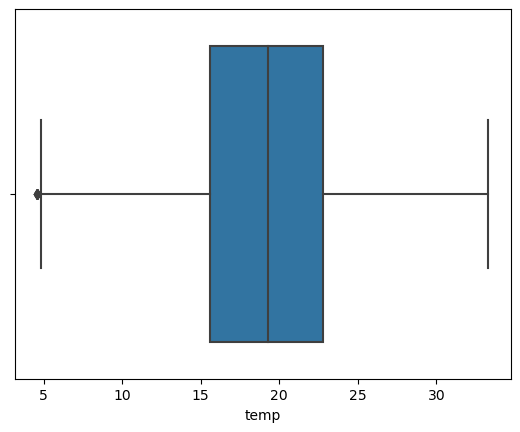

Distribution after outlier removal


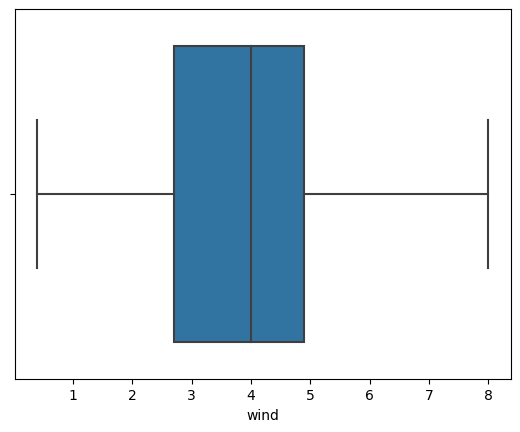

Distribution after outlier removal


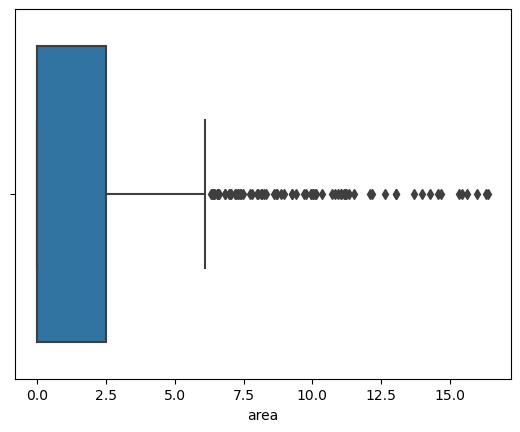

In [27]:
lst = [x for x in forestfires.columns if forestfires[x].dtype == 'float64']
for i in lst:
    if i != 'rain':
        outliers_to_median_values(forestfires,i)

We can drop month and day columns as we have the one-hot encoded versions of them in the dataset

In [28]:
forestfires = forestfires.drop(columns=['month','day'])

In [29]:
forestfires.head()

,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,dayfri,...,monthfeb,monthjan,monthjul,monthjun,monthmar,monthmay,monthnov,monthoct,monthsep,size_category
0,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0,1,...,0,0,0,0,1,0,0,0,0,small
1,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0,0,...,0,0,0,0,0,0,0,1,0,small
2,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0,0,...,0,0,0,0,0,0,0,1,0,small
3,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0,1,...,0,0,0,0,1,0,0,0,0,small
4,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0,0,...,0,0,0,0,1,0,0,0,0,small


In [30]:
X = forestfires.drop(columns='size_category')

y = forestfires['size_category']

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.30, stratify=y)

In [32]:
X_train_scaled = pd.DataFrame(ss.fit_transform(X_train),columns=X_train.columns)
X_train_scaled.head()

,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,dayfri,...,monthdec,monthfeb,monthjan,monthjul,monthjun,monthmar,monthmay,monthnov,monthoct,monthsep
0,0.906968,0.624838,0.177126,-0.022271,-0.257721,0.483483,1.232596,-0.098687,-0.558633,-0.446470,...,-0.14062,-0.193278,-0.052705,-0.254748,-0.200863,-0.34802,-0.074639,-0.052705,-0.177281,-0.692465
1,2.321289,1.367782,0.495693,1.774193,2.295766,-1.086663,-1.057442,-0.098687,3.464943,-0.446470,...,-0.14062,-0.193278,-0.052705,-0.254748,-0.200863,-0.34802,-0.074639,-0.052705,-0.177281,-0.692465
2,-0.833735,0.026206,1.257357,-0.257873,-0.500910,0.860318,-0.166872,-0.098687,2.171259,2.239792,...,-0.14062,-0.193278,-0.052705,-0.254748,-0.200863,-0.34802,-0.074639,-0.052705,-0.177281,1.444116
3,-1.160117,0.026206,1.210606,0.537283,-1.491038,2.053630,0.087577,-0.098687,-0.558633,-0.446470,...,-0.14062,-0.193278,-0.052705,-0.254748,-0.200863,-0.34802,-0.074639,-0.052705,-0.177281,1.444116
4,-0.126575,1.371345,0.254906,-0.198973,0.958225,-0.018964,0.087577,-0.098687,0.318440,-0.446470,...,-0.14062,-0.193278,-0.052705,-0.254748,-0.200863,-0.34802,-0.074639,-0.052705,-0.177281,-0.692465


In [33]:
X_test_scaled = pd.DataFrame(ss.fit_transform(X_test),columns=X_test.columns)
X_test_scaled.head()

,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,dayfri,...,monthdec,monthfeb,monthjan,monthjul,monthjun,monthmar,monthmay,monthnov,monthoct,monthsep
0,-0.557501,-0.025663,1.085834,-0.554100,-0.863074,1.909484,2.122247,-0.096674,-0.582135,-0.436852,...,-0.113961,-0.216748,-0.080322,-0.261712,-0.140028,-0.326164,0.0,0.0,-0.162221,1.355125
1,-1.903266,-0.673450,0.575684,-0.929172,0.348130,-0.423167,-1.274549,-0.096674,-0.582135,2.289105,...,-0.113961,-0.216748,-0.080322,-0.261712,-0.140028,-0.326164,0.0,0.0,-0.162221,1.355125
2,-0.221059,-0.054373,-0.424348,-0.005918,0.615307,0.276628,-0.747460,-0.096674,-0.582135,-0.436852,...,-0.113961,-0.216748,-0.080322,3.820995,-0.140028,-0.326164,0.0,0.0,-0.162221,-0.737939
3,-0.108912,-1.760872,-2.234237,-1.823575,-2.288020,0.568210,1.068069,-0.096674,0.714592,-0.436852,...,-0.113961,-0.216748,-0.080322,-0.261712,-0.140028,-0.326164,0.0,0.0,-0.162221,-0.737939
4,0.059309,1.790296,0.428202,-0.236732,1.220909,-0.889697,-1.274549,-0.096674,-0.236154,-0.436852,...,-0.113961,-0.216748,-0.080322,-0.261712,-0.140028,-0.326164,0.0,0.0,-0.162221,-0.737939


## ANN

## MLP Classifier

In [34]:
nncl = MLPClassifier(hidden_layer_sizes=15
                     ,max_iter=3000
                     ,solver='adam'
                     ,activation='logistic'
                     ,verbose=True
                     ,tol=0.0001,
                     learning_rate='constant',
                     learning_rate_init=0.001
)

In [35]:
nncl.fit(X_train_scaled,y_train)

Iteration 1, loss = 0.66274101
Iteration 2, loss = 0.65824949
Iteration 3, loss = 0.65394900
Iteration 4, loss = 0.65000670
Iteration 5, loss = 0.64602955
Iteration 6, loss = 0.64197107
Iteration 7, loss = 0.63832391
Iteration 8, loss = 0.63440928
Iteration 9, loss = 0.63097040
Iteration 10, loss = 0.62758257
Iteration 11, loss = 0.62411085
Iteration 12, loss = 0.62084996
Iteration 13, loss = 0.61780633
Iteration 14, loss = 0.61447434
Iteration 15, loss = 0.61170231
Iteration 16, loss = 0.60891889
Iteration 17, loss = 0.60613259
Iteration 18, loss = 0.60342787
Iteration 19, loss = 0.60100514
Iteration 20, loss = 0.59875364
Iteration 21, loss = 0.59618881
Iteration 22, loss = 0.59394715
Iteration 23, loss = 0.59188606
Iteration 24, loss = 0.58973307
Iteration 25, loss = 0.58760595
Iteration 26, loss = 0.58571978
Iteration 27, loss = 0.58395735
Iteration 28, loss = 0.58225370
Iteration 29, loss = 0.58043340
Iteration 30, loss = 0.57888873
Iteration 31, loss = 0.57722156
Iteration 32, los

Iteration 348, loss = 0.42499168
Iteration 349, loss = 0.42473980
Iteration 350, loss = 0.42449836
Iteration 351, loss = 0.42423887
Iteration 352, loss = 0.42402730
Iteration 353, loss = 0.42379651
Iteration 354, loss = 0.42355686
Iteration 355, loss = 0.42331779
Iteration 356, loss = 0.42308472
Iteration 357, loss = 0.42285622
Iteration 358, loss = 0.42264076
Iteration 359, loss = 0.42241790
Iteration 360, loss = 0.42216453
Iteration 361, loss = 0.42198555
Iteration 362, loss = 0.42177540
Iteration 363, loss = 0.42154905
Iteration 364, loss = 0.42134804
Iteration 365, loss = 0.42110262
Iteration 366, loss = 0.42089743
Iteration 367, loss = 0.42069439
Iteration 368, loss = 0.42046174
Iteration 369, loss = 0.42029072
Iteration 370, loss = 0.42005914
Iteration 371, loss = 0.41987399
Iteration 372, loss = 0.41963746
Iteration 373, loss = 0.41948670
Iteration 374, loss = 0.41926552
Iteration 375, loss = 0.41906646
Iteration 376, loss = 0.41888186
Iteration 377, loss = 0.41866551
Iteration 

MLPClassifier(activation='logistic', hidden_layer_sizes=15, max_iter=3000,
              verbose=True)

In [36]:
y_train_predict = nncl.predict(X_train_scaled)
y_test_predict = nncl.predict(X_test_scaled)

In [37]:
print(metrics.confusion_matrix(y_train,y_train_predict))

[[ 54  43]
 [ 10 254]]


In [38]:
tn, fp, fn, tp = metrics.confusion_matrix(y_train,y_train_predict).ravel()
print('True Negative:',tn,'\n''False Positives:' ,fp,'\n''False Negatives:', fn,'\n''True Positives:', tp)
print(metrics.classification_report(y_train,y_train_predict))

True Negative: 54 
False Positives: 43 
False Negatives: 10 
True Positives: 254
              precision    recall  f1-score   support

       large       0.84      0.56      0.67        97
       small       0.86      0.96      0.91       264

    accuracy                           0.85       361
   macro avg       0.85      0.76      0.79       361
weighted avg       0.85      0.85      0.84       361



In [39]:
print(nncl.score(X_train_scaled, y_train))
print(nncl.score(X_test_scaled, y_test))

0.853185595567867
0.8397435897435898


Let's perform hyper-parameter tuning for the model and check whether the score are having any impact

In [44]:
nncl = MLPClassifier(hidden_layer_sizes=20
                     ,max_iter=5000
                     ,solver='sgd'
                     ,activation='tanh'
                     ,verbose=True
                     ,tol=0.0001,
                     learning_rate='adaptive',
                     learning_rate_init=0.002
)

nncl.fit(X_train_scaled,y_train)
y_train_predict = nncl.predict(X_train_scaled)
y_test_predict = nncl.predict(X_test_scaled)

print(metrics.confusion_matrix(y_train,y_train_predict))

tn, fp, fn, tp = metrics.confusion_matrix(y_train,y_train_predict).ravel()
print('True Negative:',tn,'\n''False Positives:' ,fp,'\n''False Negatives:', fn,'\n''True Positives:', tp)
print(metrics.classification_report(y_train,y_train_predict))

print(nncl.score(X_train_scaled, y_train))
print(nncl.score(X_test_scaled, y_test))

Iteration 1, loss = 0.78631584
Iteration 2, loss = 0.78344441
Iteration 3, loss = 0.77892011
Iteration 4, loss = 0.77363310
Iteration 5, loss = 0.76707585
Iteration 6, loss = 0.76024826
Iteration 7, loss = 0.75263295
Iteration 8, loss = 0.74490973
Iteration 9, loss = 0.73720016
Iteration 10, loss = 0.72925142
Iteration 11, loss = 0.72153377
Iteration 12, loss = 0.71347042
Iteration 13, loss = 0.70567973
Iteration 14, loss = 0.69830949
Iteration 15, loss = 0.69099551
Iteration 16, loss = 0.68410492
Iteration 17, loss = 0.67692213
Iteration 18, loss = 0.67023416
Iteration 19, loss = 0.66367876
Iteration 20, loss = 0.65741001
Iteration 21, loss = 0.65150913
Iteration 22, loss = 0.64559254
Iteration 23, loss = 0.63976605
Iteration 24, loss = 0.63438566
Iteration 25, loss = 0.62925027
Iteration 26, loss = 0.62409032
Iteration 27, loss = 0.61917976
Iteration 28, loss = 0.61441176
Iteration 29, loss = 0.60997602
Iteration 30, loss = 0.60543020
Iteration 31, loss = 0.60128084
Iteration 32, los

Iteration 375, loss = 0.41178075
Iteration 376, loss = 0.41178068
Iteration 377, loss = 0.41178061
Iteration 378, loss = 0.41178055
Iteration 379, loss = 0.41178050
Iteration 380, loss = 0.41178046
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Learning rate too small. Stopping.
[[ 54  43]
 [ 12 252]]
True Negative: 54 
False Positives: 43 
False Negatives: 12 
True Positives: 252
              precision    recall  f1-score   support

       large       0.82      0.56      0.66        97
       small       0.85      0.95      0.90       264

    accuracy                           0.85       361
   macro avg       0.84      0.76      0.78       361
weighted avg       0.84      0.85      0.84       361

0.8476454293628809
0.8397435897435898
